1. Scaled heatmap for quail, run on 

In [9]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

def generate_classification_task(data_size):
    n_samples = data_size # 100000
    n_features = 7
    n_informative = 7 # relevant features to explain target
    n_redundant = 0 # linear combinations of informative
    n_repeated = 0 # random copies of informative and redundant
    n_useless = n_features - n_informative - n_redundant - n_repeated # noise

    n_classes = 10
    seed = 42

    # define feature names
    def feature_names (n_items, prefix = 'feature'):
        names = []
        for i in range(n_items):
            names.append(prefix + '_' + str(i))
        return names

    inf_features = feature_names(n_informative, 'inf')
    red_features = feature_names(n_redundant, 'red')
    rep_features = feature_names(n_repeated, 'rep')
    useless_features = feature_names(n_useless, 'noise')

    feature_names = inf_features + red_features + rep_features + useless_features

    X, y = make_classification(n_samples=n_samples, 
                        n_features=n_features, 
                        n_informative=n_informative, 
                        n_redundant=n_redundant, 
                        n_repeated=n_repeated, 
                        n_classes=n_classes, 
                        n_clusters_per_class=2, 
                        weights=None, 
                        flip_y=0.03, 
                        class_sep=5.0, 
                        hypercube=True, 
                        shift=15.0, # 20
                        scale=0.5, # 2.0
                        shuffle=False, 
                        random_state=seed)

    Z=np.zeros((X.shape[0], X.shape[1]+1))
    Z[:,:-1]=X
    Z[:,-1]=y

    columns = feature_names + ['class']
    df = pd.DataFrame(Z, columns=columns)

    df = df.astype('int32')
    return df


In [54]:
%%time
seed = 42

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from synthesizers.mwem import MWEMSynthesizer # current mwem.py taken from WN Github
from synthesizers.quail import QUAILSynthesizer
from diffprivlib.models import GaussianNB as DPNB

from synthesizers.pytorch.pytorch_synthesizer import PytorchDPSynthesizer
from synthesizers.preprocessors.preprocessing import GeneralTransformer
from synthesizers.pytorch.nn.dpctgan import DPCTGAN

data_sizes = [5000,15000,25000,35000,45000]
splits = [0.1,0.3,0.5,0.7,0.9]
confidence_interval = 1
matrix = [[None for i in range(len(splits))] for i in range(len(data_sizes))]

def feature_names (n_items, prefix = 'feature'):
    names = []
    for i in range(n_items):
        names.append(prefix + '_' + str(i))
    return names

feature_names = feature_names(7, 'inf')

for i, d_s in enumerate(data_sizes):
    df = generate_classification_task(d_s)
    # Ground truth accuracy
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['class'],axis=1), df['class'], test_size=0.2, stratify = df['class'], random_state = seed) 
    clf = DPNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    # print(classification_report(y_test, y_pred))
    
    # Quail comps
    Xy_train = pd.concat([X_train, y_train], axis = 1)
    for j, eps_split in enumerate(splits):
        runs = []
        for k in range(confidence_interval):
#             synth = QUAILSynthesizer(3.0, MWEMSynthesizer, {
#                 'Q_count':600,
#                 'iterations':40,
#                 'mult_weights_iterations':30,
#                 'split_factor':2,
#                 'max_bin_count':500
#             }, DPNB, {}, 'class', eps_split=eps_split)

#             synth.fit(Xy_train)

            synth = QUAILSynthesizer(3.0, PytorchDPSynthesizer, {
                'preprocessor': None,
                'gan': DPCTGAN(loss='wasserstein', batch_size=500, pack=2, sigma=5.0)}, DPNB, {}, 'class')

            synth.fit(Xy_train, categorical_columns=['class'], ordinal_columns=feature_names)

            sample_size = Xy_train.shape[0]
            synthetic = synth.sample(int(sample_size))
            synth_df = pd.DataFrame(synthetic, columns=Xy_train.columns)

            X_train_dp = synth_df.drop('class', axis = 1)
            y_train_dp = synth_df['class']

            clf = RandomForestClassifier(random_state=seed)
            clf.fit(X_train_dp, y_train_dp)

            y_pred = clf.predict(X_test)
            f1_synth = f1_score(y_test, y_pred, average='macro')
            runs.append(f1_synth)
        # store the delta
        matrix[i][j] = f1 - np.mean(np.array(runs))
        print("Finished eps split " + str(eps_split))
        
print(matrix)

(3200, 7)
(3200, 1)
[7 7 4 ... 4 3 6]
              precision    recall  f1-score   support

           0       0.62      0.54      0.58        74
           1       0.69      0.97      0.81        79
           2       0.94      0.39      0.55        77
           3       0.67      0.25      0.36        81
           4       0.96      0.94      0.95        87
           5       0.96      0.51      0.66        87
           6       0.64      0.95      0.77        88
           7       0.55      0.82      0.66        72
           8       0.47      0.97      0.64        71
           9       0.45      0.25      0.32        84

    accuracy                           0.66       800
   macro avg       0.70      0.66      0.63       800
weighted avg       0.70      0.66      0.63       800

0.6575
Finished eps split 0.1
(3200, 7)
(3200, 1)
[7 7 4 ... 4 3 6]
              precision    recall  f1-score   support

           0       0.57      0.51      0.54        74
           1       0.64   

In [99]:
import mlflow
from mlflow.tracking.artifact_utils import _download_artifact_from_uri
from azureml.core import Workspace, Experiment

quail_exp = Experiment(Workspace.from_config(), "quail_evals_v2_higheps_4")

for i,r in enumerate(quail_exp.get_runs()):
    if r.get_status() in ['Completed']:
        r.download_file("matrix.json", 'matrices_10/matrix_4_' + str(i) + '.json')

In [130]:
import glob
import json

ds = []
for file in glob.glob("matrices_10/*.json"):
    with open(file, "r") as read_json:
        mat = json.load(read_json)
        for k,v in mat.items():
            ds.append(v)

[[ 0.02417143  0.01913571  0.02752857  0.02019286  0.01940714]
 [ 0.02235     0.01933214  0.02820357  0.02058571  0.02621429]
 [ 0.00043571 -0.00272619 -0.00037381 -0.00510952  0.00584286]
 [ 0.004575    0.00418036  0.01465893  0.00750357  0.00665357]
 [ 0.01625571  0.00667143  0.01227286  0.00631143  0.00490857]]


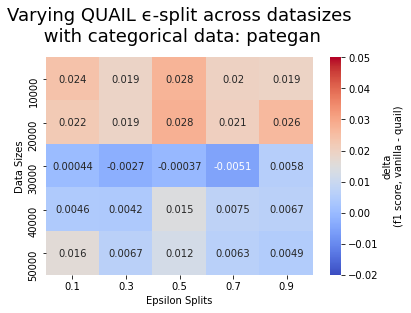

In [136]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

combined = {}
for res in ds:
    for k,v in res.items():
        if k not in combined:
            combined[k] = np.array(v)
        else:
            combined[k] = combined[k] + np.array(v)

data_sizes = [10000,20000,30000,40000,50000]
splits = [0.1,0.3,0.5,0.7,0.9]

first = 1
for k,v in combined.items():
    if first == 5:
        final_mat = v / float(len(ds))
        print(final_mat)
        m_df = pd.DataFrame(final_mat, columns=splits, index=data_sizes)
        heatmap = sns.heatmap(m_df, annot=True, vmax=0.05, vmin=-0.02, cmap='coolwarm', cbar_kws={'label': 'delta\n(f1 score, vanilla - quail)'})
        heatmap.set_title('Varying QUAIL ϵ-split across datasizes\n with categorical data: ' + k, fontdict={'fontsize':18}, pad=16);
        plt.xlabel('Epsilon Splits')
        plt.ylabel('Data Sizes')
    first += 1